## 0. Importing external modules

In [1]:
## path for mdules

import sys
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/xscale")
import xscale

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/powerspec/powerspec")
import powerspec as pp

In [3]:
sys.path.insert(0,"/scratch/cnt0024/hmg2840/albert7a/DEV/git/diags-CMEMS-on-occigen/common-lib/")
import GriddedData
import WavenumberSpectrum as ws


In [4]:
## imports

import numpy as np
import xarray as xr
import time

In [5]:
#- Other modules
import numpy.ma as ma

### palette
import matplotlib.cm as mplcm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

import glob
import os 

%matplotlib inline

In [16]:
config='GS36'
case='MPC001'
freq='1d'

year='2012'


In [17]:
if case == 'MPC001':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/'+config+'/'+config+'-I/coordinates_'+config+'.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/'+config+'/'+config+'-I/'+config+'.L75_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36.L75-MAA007_mesh_mask.nc'
if case == 'MPC002':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_1/coordinates_EU36.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_1/EU36.L150_1_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_1/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_1/GS36.L150_1_mesh_mask.nc'
if case == 'MPC003':
    if config == 'EU36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_2/coordinates_EU36.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I.L150_2/EU36.L150_2_mesh_mask.nc'
    if config == 'GS36':
        gridfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_2/GS36_coordinates.nc'
        maskfile='/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I.L150_2/GS36.L150_2_mesh_mask.nc'
 

In [18]:
## Dataset

dirs="/scratch/cnt0024/hmg2840/colombo/GS36/GS36-MPC001-S/1d/2010/"
dirin="/scratch/cnt0024/hmg2840/colombo/GS36/GS36-I-Aur/"


In [19]:
grid=xr.open_dataset(gridfile)
navlat= grid['nav_lat']
navlon= grid['nav_lon']


In [20]:
navlat

<xarray.DataArray 'nav_lat' (y: 950, x: 1468)>
[1394600 values with dtype=float32]
Dimensions without coordinates: y, x
Attributes:
    valid_min:         -10.933042
    valid_max:         76.83486
    units:             N/A
    long_name:         N/A
    short_name:        N/A
    iweight:           1
    online_operation:  N/A
    axis:              N/A
    savelog10:         0.0

In [21]:
def filt(w):
    win_box2D = w.window
    win_box2D.set(window='hanning', cutoff=54, dim=['x', 'y'], n=[54, 54])
    bw = win_box2D.boundary_weights(drop_dims=[])
    w_LS = win_box2D.convolve(weights=bw)
    w_SS=w-w_LS
    return w_SS


In [22]:
    month='03'
    date_list=[]
    if month == '03':
        dayf=31
    if month == '09':
        dayf=30
    for day in np.arange(1,dayf+1):
        if day < 10:
            date='y'+str(year)+'m'+str(month)+'d0'+str(day)
        else:
            date='y'+str(year)+'m'+str(month)+'d'+str(day)
        date_list.append(date)
    datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'
    for date in date_list:
        fileU=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridU.nc'
        fileV=datadir+'*/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_gridV.nc'
        filecurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_'+str(date)+'.'+str(freq)+'_socurloverf.nc'
        if not os.path.exists(filecurl):
            print('Computing '+str(filecurl))
            !ln -sf $maskfile mesh_hgr.nc
            !ln -sf $maskfile mesh_zgr.nc
            !cdfcurl -u $fileU vozocrtx -v $fileV vomecrty -l 1 -surf -overf -o $filecurl
            !rm mesh*
    filescurl='/scratch/cnt0024/hmg2840/albert7a/tmp/'+str(config)+'-'+str(case)+'_y'+str(year)+'m'+str(month)+'d??.'+str(freq)+'_socurloverf.nc'
    dscurl=xr.open_mfdataset(filescurl,chunks={'time_counter':1,'y':700,'x':1000})
    curl=dscurl.socurloverf
    curl_SS=filt(curl)
    curl_LS=curl-curl_SS
 

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


In [26]:
!ls $filescurl

/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d01.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d02.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d03.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d04.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d05.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d06.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d07.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d08.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d09.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d10.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d11.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS36-MPC001_y2012m03d12.1d_socurloverf.nc
/scratch/cnt0024/hmg2840/albert7a/tmp/GS

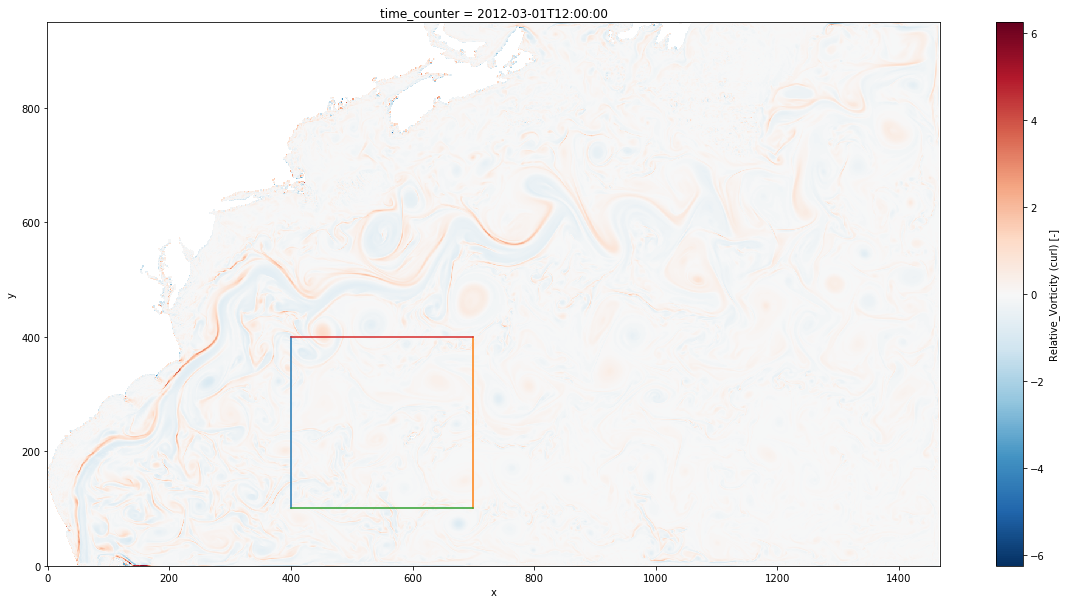

In [28]:
fig=plt.figure(figsize=(20,10))
ax = plt.subplot(111)
curl[0].plot()

ax.plot([400, 400], [100, 400])
ax.plot([700, 700], [100, 400])
ax.plot([400, 700], [100, 100])
ax.plot([400, 700], [400, 400])


In [29]:
zlat= navlat[100:400,400:700].values
zlon= navlon[100:400,400:700].values
zfull = curl[0,100:400,400:700].values
zhp = curl_SS[0,100:400,400:700].values
zlp = zfull - zhp

In [30]:
def compute_spectrum(var):
    data = var.squeeze()
    pspec,kstep = pp.wavenumber_spectra(data,zlon,zlat)
    return pspec, kstep

%time spectre_full = compute_spectrum(zfull)
%time spectre_hp   = compute_spectrum(zhp)
%time spectre_lp   = compute_spectrum(zlp)


CPU times: user 2.49 s, sys: 4.81 s, total: 7.3 s
Wall time: 447 ms
CPU times: user 1.43 s, sys: 2.95 s, total: 4.38 s
Wall time: 150 ms
CPU times: user 1.25 s, sys: 2.55 s, total: 3.8 s
Wall time: 135 ms


In [34]:
rad2cyc = 1.E3 / np.pi / 2. 

def nice_spectrum(spectre_full,spectre_hp,spectre_lp,title,figname):
    fig, axarr = plt.subplots(1,1)
    fig.set_figheight(8)
    fig.set_figwidth(15)
    #
    pspec,kstep = spectre_full
    pspec_lp,kstep_lp = spectre_lp
    pspec_hp,kstep_hp = spectre_hp
    skpspec = pspec * rad2cyc
    skpspec_lp = pspec_lp * rad2cyc
    skpspec_hp = pspec_hp * rad2cyc
    axarr.plot(skpspec[1:],kstep[1:], 'k-', lw=3, label='Full relative vorticity')
    axarr.plot(skpspec_hp[1:],kstep_hp[1:], 'b-', lw=3, label='hanning')
    axarr.set_xscale('log')
    axarr.set_yscale('log')
    axarr.set_title('',fontsize=20)
    axarr.grid(True,which='both',ls='-')
    axarr.axis('tight')
    axarr.legend(loc="lower left", fontsize=25)
    axarr.tick_params(labelsize=25)
    plt.title(title, fontsize=25)
    plt.savefig(figname)



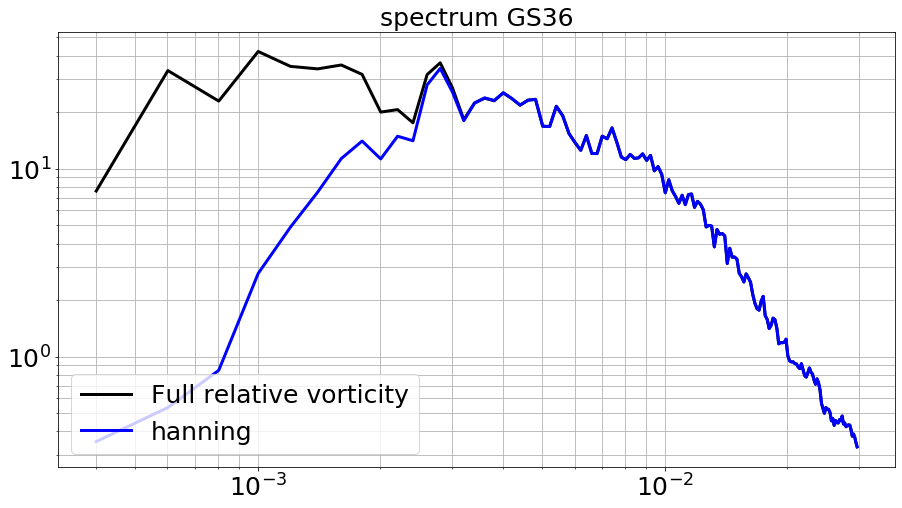

In [35]:
nice_spectrum(spectre_full,spectre_hp,spectre_lp,'spectrum GS36','spectrum_GS36.png')
